In [1]:
import jax
import jax.numpy as np

import numpy as onp
from numpy.polynomial.hermite import hermgauss

from structure_vb_lib import structure_model_lib, posterior_quantities_lib, data_utils, plotting_utils
import structure_vb_lib.structure_optimization_lib as s_optim_lib

from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation
from bnpmodeling_runjingdev.bnp_optimization_lib import optimize_kl
from bnpmodeling_runjingdev import influence_lib, cluster_quantities_lib, result_loading_utils
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
save_data = True
out_datadir = '/scratch/users/genomic_times_series_bnp/bnp_sensitivity_paper_data/structure/'

# Load data

In [3]:
g_obs, _, labels, _ = data_utils.load_thrush_data()

loading thrush data from : 
../data/thrush_data/thrush-data.str


In [4]:
print(g_obs.shape)

(155, 7, 2, 21)


In [5]:
n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]
n_allele = g_obs.shape[-1]

# Load initial fit

In [6]:
vb_opt_dict, vb_params_paragami, init_fit_metadata = \
        paragami.load_folded('../fits/main_fits/structure_initial_fit.npz')
    
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

In [7]:
# TODO we should save this too
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

# Load refits

In [8]:
out_folder = '../fits/main_fits/'
match_crit = 'structure_fsens_mbololo_epsilonindx\d+.npz'

In [9]:
refit_list, epsilon_vec, meta_data_list = \
    result_loading_utils.load_refit_files_epsilon(out_folder, match_crit)

In [10]:
print(epsilon_vec)

[0.         0.02040816 0.08163265 0.18367347 0.32653061 0.51020408
 0.73469388 1.        ]


# Plot initial fit

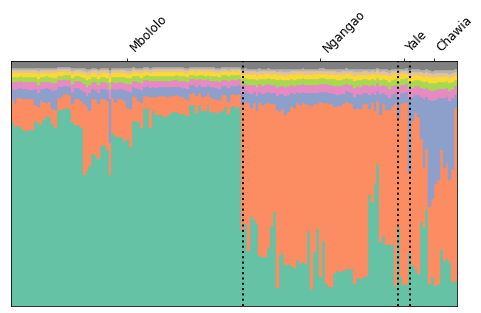

In [11]:
e_ind_admix = posterior_quantities_lib.get_vb_expectations(vb_opt_dict, gh_loc, gh_weights)[0]

# sort everything within populations
perm_obs = data_utils.cluster_admix_get_indx_within_labels(onp.array(e_ind_admix),
                                                               labels)

# now re-order populations: put chawia last
_labels = deepcopy(labels)
_labels[_labels == 'Chawia'] = 'z'
perm_labels = onp.argsort(_labels)
perm_obs = perm_obs[perm_labels]

# plot admixture
fig, ax = plt.subplots(1, 1, figsize = (8, 4.5))

plotting_utils.plot_top_clusters(onp.array(e_ind_admix)[perm_obs], 
                                 ax,
                                 8, 
                                 cmap_colors = plt.get_cmap('Set2').colors);

# print labels
plotting_utils.draw_region_separation(labels[perm_labels], ax);

# Load LR predictions

In [12]:
lr_results = np.load('../fits/main_fits/structure_mbololo_lr_results.npz')

In [13]:
# the free parameters
lr_list = lr_results['lr_list']

# the derivative itself
dinput_dhyper = lr_results['dinput_dhyper']

# Check free parameters

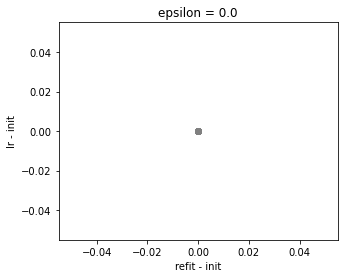

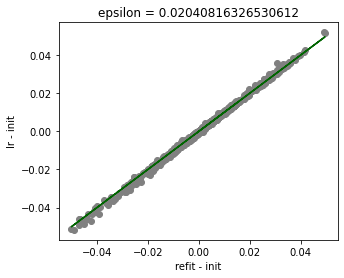

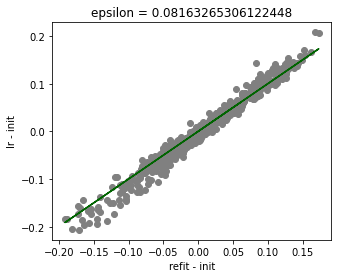

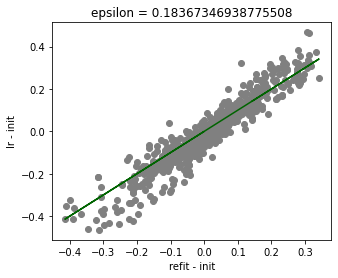

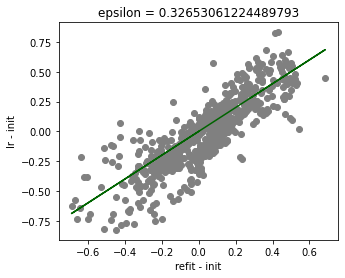

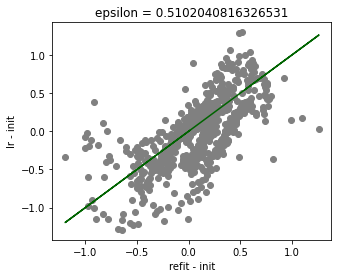

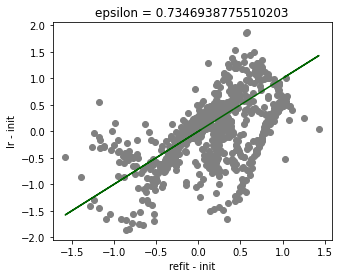

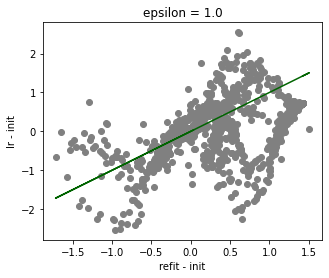

In [14]:
for i in range(len(epsilon_vec)): 
    fig, ax = plt.subplots(1, 1, figsize = (5, 4))

    result_loading_utils.print_diff_plot(refit_list[i], 
                                         lr_list[i],
                                         vb_opt,
                                         ax, 
                                         alpha = 1.)
    
    plt.title('epsilon = {}'.format(epsilon_vec[i]))
    

# Plot admixtures

In [15]:
def get_inferred_admixture_and_plot(vb_free_params, ax): 
    # get inferred admixture
    e_ind_admix = posterior_quantities_lib.get_vb_expectations(\
                                            vb_params_paragami.fold(vb_free_params, free = True), 
                                            gh_loc,
                                            gh_weights)[0]
    
    # plot admixtures
    plotting_utils.plot_top_clusters(onp.array(e_ind_admix)[perm_obs], 
                                     ax,
                                     8, 
                                     cmap_colors = plt.get_cmap('Set2').colors);

    # print labels 
    plotting_utils.draw_region_separation(labels[perm_labels], ax);
    
    return e_ind_admix

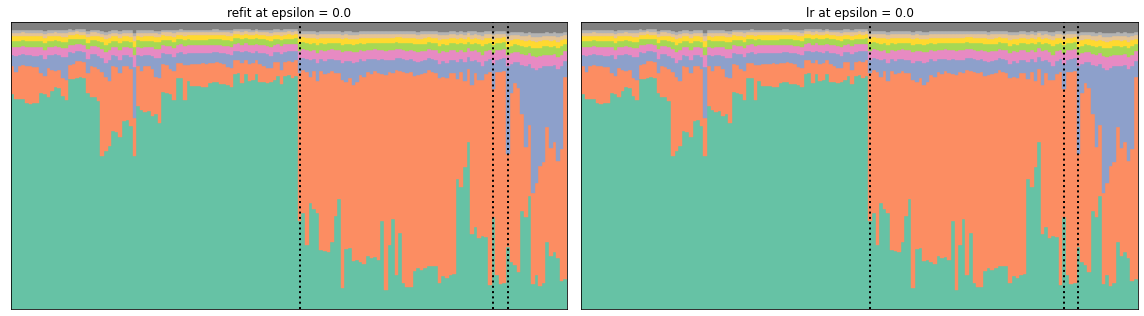

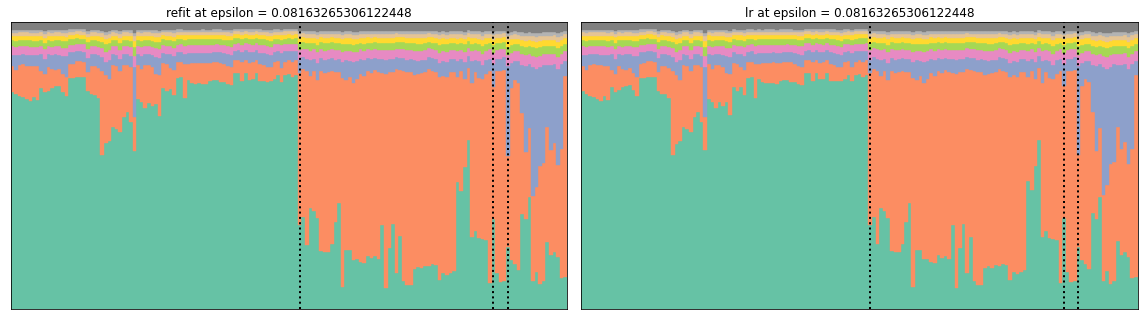

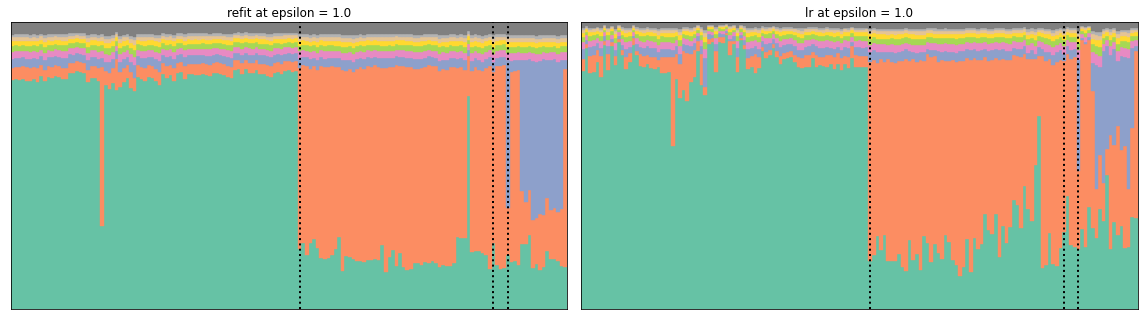

In [16]:
which_epsilons = [0, 2, -1]

admix_lr_list = []
admix_refit_list = []

for i in which_epsilons: 

    fig, ax = plt.subplots(1, 2, figsize = (16, 4.5))
    
    ax[0].set_title('refit at epsilon = {}'.format(epsilon_vec[i]))
    ax[1].set_title('lr at epsilon = {}'.format(epsilon_vec[i]))
    
    # refit
    admix_refit = get_inferred_admixture_and_plot(refit_list[i], ax[0])
    
    # lr 
    admix_lr = get_inferred_admixture_and_plot(lr_list[i], ax[1])
    
    # just remove these labels for now
    for j in range(2): 
        ax[j].set_xticks([]) 

    fig.tight_layout()
    
    
    admix_refit_list.append(admix_refit)
    admix_lr_list.append(admix_lr)

# Lets look at that long strip in the mbololo region ... 

In [17]:
e_ind_admix_pert = admix_refit_list[-1]

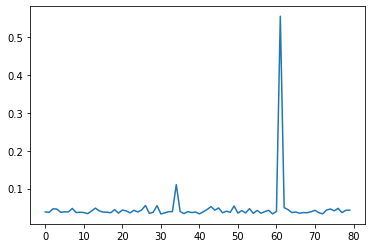

In [18]:
plt.plot(e_ind_admix_pert[labels == 'Mbololo'][:, 1])

In [19]:
np.argwhere((labels == 'Mbololo') & (e_ind_admix_pert[:, 1] > 0.5))

DeviceArray([[78]], dtype=int64)

In [20]:
n = 78

In [21]:
np.argwhere((labels[perm_labels] == 'Mbololo') & (e_ind_admix_pert[perm_obs, 1] > 0.5))

DeviceArray([[25]], dtype=int64)

### expected admixture

In [22]:
def get_e_ind_admix_nk(vb_free, n, k): 
    e_ind_admix = posterior_quantities_lib.get_vb_expectations(\
                                            vb_params_paragami.fold(vb_free, free = True), 
                                            gh_loc,
                                            gh_weights)[0]
    
    return e_ind_admix[n, k]

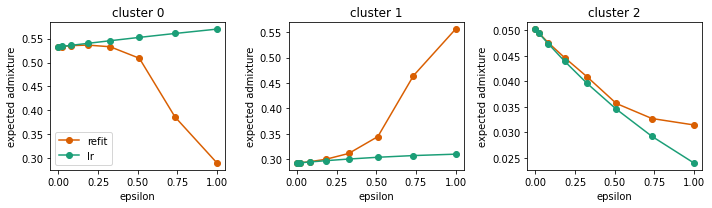

In [23]:
fig, axarr = plt.subplots(1, 3, figsize = (10, 3), sharey = False)


for k in range(3): 
    result_loading_utils.plot_post_stat_per_epsilon(lambda x : get_e_ind_admix_nk(x, n, k),
                                                    refit_list,
                                                    lr_list,
                                                    epsilon_vec, 
                                                    axarr[k])
    
    axarr[k].set_title('cluster {}'.format(k))
    axarr[k].set_ylabel('expected admixture')
    
axarr[0].legend()
fig.tight_layout()

### the actual variational parameter: the logit-stick location

In [24]:
def get_stick_loc_nk(vb_free, n, k): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return vb_params_dict['ind_admix_params']['stick_means'][n, k]

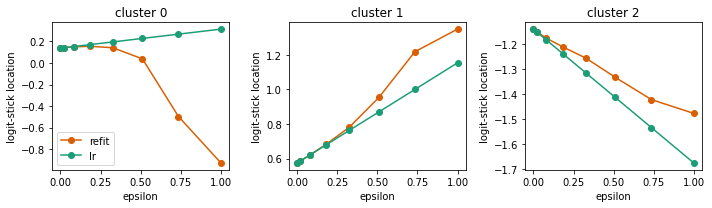

In [25]:
fig, axarr = plt.subplots(1, 3, figsize = (10, 3), sharey = False)


for k in range(3): 
    result_loading_utils.plot_post_stat_per_epsilon(lambda x : get_stick_loc_nk(x, n, k),
                                                    refit_list,
                                                    lr_list,
                                                    epsilon_vec, 
                                                    axarr[k])
    
    axarr[k].set_title('cluster {}'.format(k))
    axarr[k].set_ylabel('logit-stick location')
    
axarr[0].legend()
fig.tight_layout()

# save results

### Save structure plot

In [26]:
if save_data: 
    np.savez(out_datadir + 'mbololo_fsens_admix_example', 
         epsilon = epsilon_vec[-1], 
         admix_refit = admix_refit_list[-1][perm_obs], 
         admix_lr = admix_lr_list[-1][perm_obs])

In [27]:
import pandas as pd 

In [28]:
def get_post_stat_df(g, refit_list, lr_list): 
    
    refit_vec = \
        result_loading_utils.get_post_stat_vec(g, refit_list)
    
    lr_vec = \
        result_loading_utils.get_post_stat_vec(g, lr_list)
    
    
    refit_df = pd.DataFrame({'y': refit_vec, 
                             'epsilon': epsilon_vec, 
                             'population': k + 1, 
                             'epsilon': epsilon_vec, 
                             'method': 'refit'})


    lr_df = pd.DataFrame({'y': lr_vec, 
                          'epsilon': epsilon_vec, 
                          'population': k + 1, 
                          'epsilon': epsilon_vec, 
                          'method': 'lin'})
    
    return refit_df.append(lr_df)

### save logit stick location parameter

In [29]:
logit_stick_loc_df = pd.DataFrame()

for k in range(3):
    
    df_k = get_post_stat_df(lambda x : get_stick_loc_nk(x, n, k),
                            refit_list, 
                            lr_list)
    
    logit_stick_loc_df = logit_stick_loc_df.append(df_k)

In [30]:
logit_stick_loc_df.to_csv(out_datadir + 'mbololo_logit_stick_bad_example.csv')

### save mixture weights

In [31]:
admix_i_df = pd.DataFrame()

for k in range(3):
    
    df_k = get_post_stat_df(lambda x : get_e_ind_admix_nk(x, n, k),
                            refit_list, 
                            lr_list)
    
    admix_i_df = admix_i_df.append(df_k)

In [32]:
admix_i_df.to_csv(out_datadir + 'mbololo_admix_bad_example.csv')

# an example where fully-linearized was successful

In [33]:
refit_diff = admix_refit_list[-1] - admix_refit_list[0]
lr_diff = admix_lr_list[-1] - admix_lr_list[0]

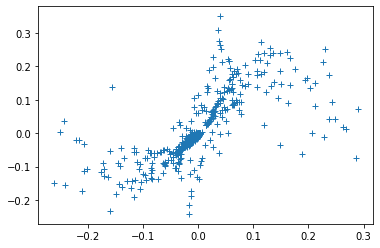

In [34]:
plt.plot(refit_diff.flatten(), 
         lr_diff.flatten(), '+')

In [35]:
foo = np.argwhere(np.sign(refit_diff) != np.sign(lr_diff))

In [36]:
foo[foo[:, 1] == 2]

DeviceArray([[ 5,  2],
             [ 7,  2],
             [11,  2],
             [15,  2]], dtype=int64)

In [37]:
n = 11

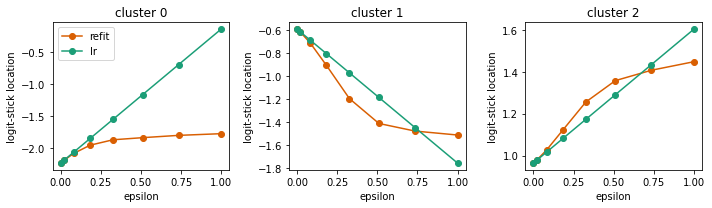

In [38]:
fig, axarr = plt.subplots(1, 3, figsize = (10, 3), sharey = False)


for k in range(3): 
    result_loading_utils.plot_post_stat_per_epsilon(lambda x : get_stick_loc_nk(x, n, k),
                                                    refit_list,
                                                    lr_list,
                                                    epsilon_vec, 
                                                    axarr[k])
    
    axarr[k].set_title('cluster {}'.format(k))
    axarr[k].set_ylabel('logit-stick location')
    
axarr[0].legend()
fig.tight_layout()

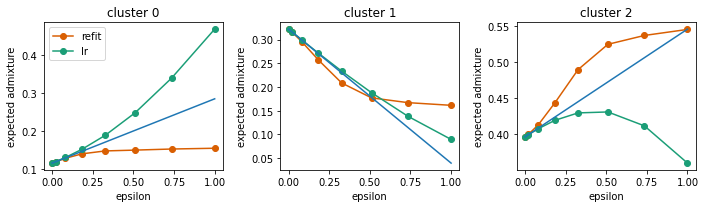

In [39]:
fig, axarr = plt.subplots(1, 3, figsize = (10, 3), sharey = False)

lr_full_array = []

for k in range(3): 
    
    g = lambda x : get_e_ind_admix_nk(x, n, k)
    
    result_loading_utils.plot_post_stat_per_epsilon(g,
                                                    refit_list,
                                                    lr_list,
                                                    epsilon_vec, 
                                                    axarr[k])
    
    axarr[k].set_title('cluster {}'.format(k))
    axarr[k].set_ylabel('expected admixture')
    
    # fully-linearized approach
    grad_g = jax.grad(g)(vb_opt)
    lr_full = (grad_g * dinput_dhyper.squeeze()).sum() * epsilon_vec + g(lr_list[0])
    
    axarr[k].plot(epsilon_vec, lr_full)
    
    lr_full_array.append(lr_full)
    
axarr[0].legend()
fig.tight_layout()

### save results again

In [40]:
logit_stick_loc_df = pd.DataFrame()

for k in range(3):
    
    df_k = get_post_stat_df(lambda x : get_stick_loc_nk(x, n, k),
                            refit_list, 
                            lr_list)
    
    logit_stick_loc_df = logit_stick_loc_df.append(df_k)
    
logit_stick_loc_df.to_csv(out_datadir + 'mbololo_logit_stick_fully_lin.csv')

In [41]:
admix_i_df = pd.DataFrame()

for k in range(3):
    
    df_k = get_post_stat_df(lambda x : get_e_ind_admix_nk(x, n, k),
                            refit_list, 
                            lr_list)
    
    # the fully-linearized version 
    df_k['fully_lin'] = np.concatenate((lr_full_array[k], ) * 2)
    
    admix_i_df = admix_i_df.append(df_k)
    
admix_i_df.to_csv(out_datadir + 'mbololo_admix_fully_lin.csv')

In [44]:
perm_obs[11]

74